## Description:

    Evaluate community differences between treated seeds and untreated controlls



# Init

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R

library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)
library(vegan)
library(DESeq2)
library(phyloseq)

/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: iterators

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:gridExtra’:

    combine


  warnings.warn(x, RRuntimeWarning)
/opt/anacon

In [3]:
%%R
# set theme for ggplot

theme_pub = function (base_size = 11, base_family = "Helvetica") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE)
    }


# Loading phyloseq object

In [4]:
%%R
setwd('/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/')

In [5]:
%%R 
# loading

physeq = readRDS('ERA_snorm.rds')

#remove T0, not necessary
physeq = subset_samples(physeq, !is.na(Genotype), TRUE)
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4597 taxa and 236 samples ]
sample_data() Sample Data:       [ 236 samples by 33 sample variables ]
tax_table()   Taxonomy Table:    [ 4597 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4597 tips and 4596 internal nodes ]


In [6]:
%%R
sample_data(physeq)$Rep = as.factor(sample_data(physeq)$Rep)
sample_data(physeq)$Row = as.factor(sample_data(physeq)$Row)
sample_data(physeq)$Fert = as.factor(sample_data(physeq)$Fert)

In [11]:
%%R
sample_data(physeq)$Plant %>%
    levels

 [1] "322"     "322U"    "330"     "339"     "3394"    "3475"    "3475U"  
 [8] "34M95"   "34N42"   "34N42U"  "3517"    "354"     "3541"    "354U"   
[15] "3618"    "Bare"    "P1151HR"


* 322, 3475, 34N42, and 354 have plots with both treated and untreated seeds that were sampled at T2

In [12]:
%%R
phy.st = subset_samples(physeq, Genotype %in% c("322", "3475", "34N42", "354") & TimePoint == "T2")
phy.st

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4597 taxa and 32 samples ]
sample_data() Sample Data:       [ 32 samples by 33 sample variables ]
tax_table()   Taxonomy Table:    [ 4597 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4597 tips and 4596 internal nodes ]


In [13]:
%%R
sample_data(phy.st)$R_Year %>%
    unique

[1] 1936 2003 1953 1984


* does not include treated plants with multivariate outliers

# Calculate distances matrices 

In [14]:
%%R
registerDoParallel(cores=28)
wunif.dist = phyloseq::distance(phy.st, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [15]:
%%R
registerDoParallel(cores=28)
bray.dist = distance(phy.st, 
                      method = "bray", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [16]:
%%R
phy.st %>% 
    sample_data() %>%
    colnames()

 [1] "X.sampleID"      "TubeID"          "ExtractionPlate" "PooledDNAPlate" 
 [5] "Sample.Well.ID"  "PrimerPlate"     "Primer.Number"   "Primer.Well.ID" 
 [9] "X"               "primerFwdLoc"    "primerRevLoc"    "fwd_barcode"    
[13] "rev_barcode"     "PlotID"          "TimePoint"       "Rep"            
[17] "Row"             "Pos"             "Fert"            "PlotIndex"      
[21] "Plant"           "Genotype"        "SeedTreatment"   "R_Year"         
[25] "ERA"             "kgdw_ha"         "FracN.leco"      "FracC.leco"     
[29] "d15N"            "X15N_AtPercent"  "FracN"           "FracN_fromSoil" 
[33] "FracN_fromFert" 


In [17]:
%%R
phy.st %>% 
    sample_data() %>%
    .$Genotype %>%
    levels()

[1] "322"   "3475"  "34N42" "354"  


# NMDS of w-Unifrac

In [18]:
%%R
## Taking distance matrix and making NNMDS rank values with vegan function metaMDS
### k = dimensions (usually 2 or 3 used), trymax can give more attempts to reach solution than the default that phyloseq uses

dist.bray.nmds = metaMDS(bray.dist,autotransform=F,k=3,trymax=50)




Run 0 stress 0.09122349 
Run 1 stress 0.09122452 
... Procrustes: rmse 0.0004436305  max resid 0.002132104 
... Similar to previous best
Run 2 stress 0.09122346 
... New best solution
... Procrustes: rmse 0.0001212909  max resid 0.00054307 
... Similar to previous best
Run 3 stress 0.09122371 
... Procrustes: rmse 0.0002139388  max resid 0.001008933 
... Similar to previous best
Run 4 stress 0.09122663 
... Procrustes: rmse 0.0009815257  max resid 0.004643621 
... Similar to previous best
Run 5 stress 0.09122377 
... Procrustes: rmse 0.0002880704  max resid 0.001383258 
... Similar to previous best
Run 6 stress 0.09122369 
... Procrustes: rmse 0.0002382388  max resid 0.0008187851 
... Similar to previous best
Run 7 stress 0.09122626 
... Procrustes: rmse 0.0009175158  max resid 0.004365326 
... Similar to previous best
Run 8 stress 0.0912235 
... Procrustes: rmse 0.0001177532  max resid 0.0005041125 
... Similar to previous best
Run 9 stress 0.09122354 
... Procrustes: rmse 7.889339e-0

In [19]:
%%R -w 800 -h 350


p = plot_ordination(phy.st, dist.bray.nmds, justDF = TRUE)



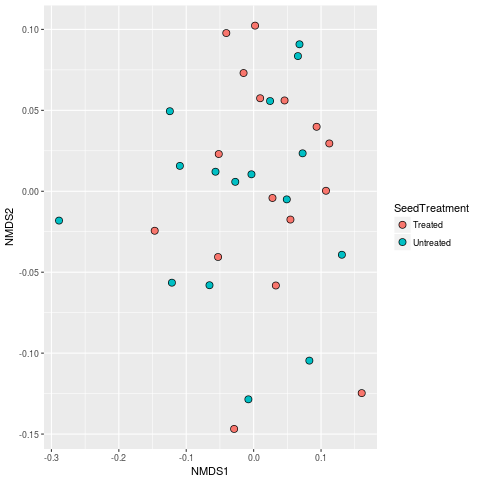

In [20]:
%%R
## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=SeedTreatment), pch = 21, size = 3)
        #scale_size(range=c(2,8))

#p2 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        #geom_point(aes(fill=Plant, size = BD), pch=21) +
        #scale_size(range=c(2,8))

grid.arrange(p1, ncol=1)

# Adonis testing treatment effects

* Weighted UniFrac

In [21]:
%%R
set.seed(101)

df = as(sample_data(phy.st), "data.frame")
d = wunif.dist
#df$Fert = as.factor(df$Fert)
Fulladonis = adonis(formula = d ~ Rep + Genotype + SeedTreatment, df, 
                    permutations = 999)
Fulladonis


Call:
adonis(formula = d ~ Rep + Genotype + SeedTreatment, data = df,      permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

              Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)   
Rep            3  0.039066 0.0130221 2.22384 0.19478  0.004 **
Genotype       3  0.014107 0.0047024 0.80304 0.07034  0.740   
SeedTreatment  1  0.006854 0.0068542 1.17052 0.03417  0.258   
Residuals     24  0.140536 0.0058557         0.70071          
Total         31  0.200564                   1.00000          
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


* Using unweighted bray-curtis distance

In [22]:
%%R
set.seed(101)

df = as(sample_data(phy.st), "data.frame")
d = bray.dist
#df$Fert = as.factor(df$Fert)
Fulladonis = adonis(formula = d ~ Rep + Genotype + SeedTreatment, df, 
                    permutations = 999)
Fulladonis


Call:
adonis(formula = d ~ Rep + Genotype + SeedTreatment, data = df,      permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

              Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Rep            3   0.25236 0.084121 2.08913 0.18367  0.001 ***
Genotype       3   0.11705 0.039018 0.96901 0.08519  0.546    
SeedTreatment  1   0.03823 0.038230 0.94943 0.02782  0.489    
Residuals     24   0.96638 0.040266         0.70332           
Total         31   1.37403                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


* unweighted UniFrac

In [23]:
%%R
set.seed(101)

df = as(sample_data(phy.st), "data.frame")
d = wunif.dist
#df$Fert = as.factor(df$Fert)
Fulladonis = adonis(formula = d ~ Rep + Genotype*SeedTreatment, df, 
                    permutations = 999)
Fulladonis


Call:
adonis(formula = d ~ Rep + Genotype * SeedTreatment, data = df,      permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                       Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)   
Rep                     3  0.039066 0.0130221 2.28722 0.19478  0.004 **
Genotype                3  0.014107 0.0047024 0.82593 0.07034  0.706   
SeedTreatment           1  0.006854 0.0068542 1.20388 0.03417  0.246   
Genotype:SeedTreatment  3  0.020975 0.0069915 1.22800 0.10458  0.211   
Residuals              21  0.119562 0.0056934         0.59613          
Total                  31  0.200564                   1.00000          
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


* SeedTreatment is not significant with any distance matrix.

In [25]:
%%R
ordMean = p %>% 
    group_by(Genotype, R_Year, SeedTreatment) %>%
    summarize(mAxis.1 = mean(NMDS1),
                seAxis.1 = sd(NMDS1)/sqrt(length(NMDS1)),
             mAxis.2 = mean(NMDS2), 
             seAxis.2 = sd(NMDS2)/sqrt(length(NMDS2)))

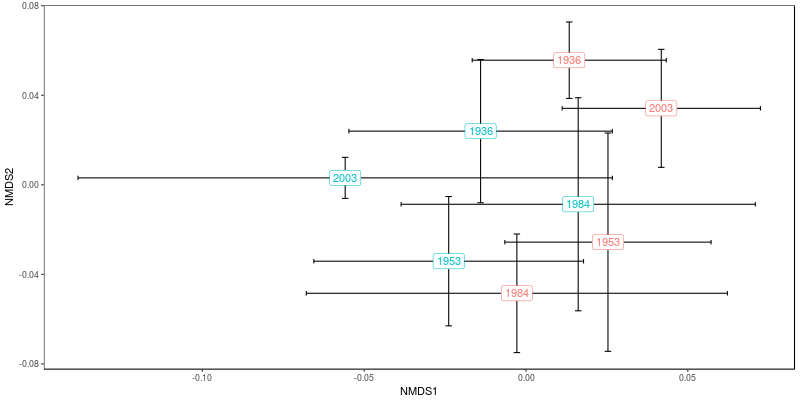

In [32]:
%%R -w 800 -h 400
p1 = ggplot(ordMean, aes(x = mAxis.1, y = mAxis.2, label = R_Year, color = SeedTreatment)) +
    geom_point()+
    theme_pub()+
    geom_errorbar(aes(ymin = mAxis.2 - seAxis.2, ymax = mAxis.2 + seAxis.2),      
                color = "black",
                width = .002) +
    geom_errorbarh(aes(xmin = mAxis.1 - seAxis.1, xmax = mAxis.1 + seAxis.1),color = "black",
                height = .002)+
    geom_label(aes(color = SeedTreatment)) +
    theme(legend.position = "none")+
    xlab("NMDS1")+
    ylab("NMDS2")
p1

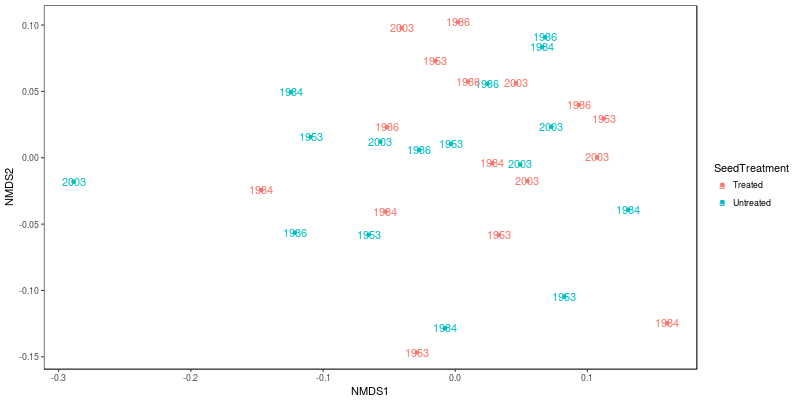

In [31]:
%%R -w 800 -h 400
p2 = ggplot(p, aes(x = NMDS1, y = NMDS2, label = R_Year, color = SeedTreatment)) +
    geom_point()+
    theme_pub()+
    geom_text(aes(color = SeedTreatment)) +
    #theme(legend.position = "none")+
    xlab("NMDS1")+
    ylab("NMDS2")
p2

In [ ]:
* No detectable influence of seed treatment on overall community

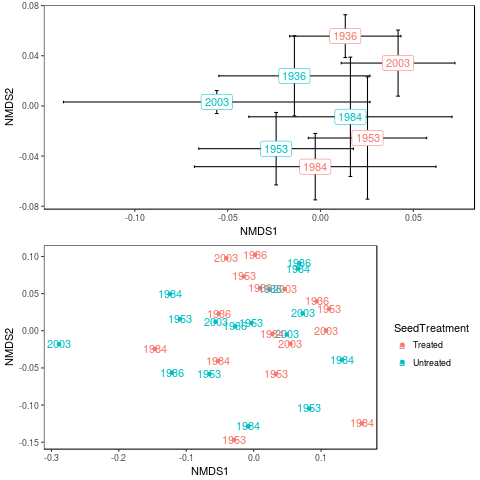

In [33]:
%%R
grid.arrange(p1, p2, ncol = 1)

# DESeq2 analysis 

In [34]:
%%R 
# loading raw counts for DESeq

phy.thresh = readRDS('ERA_thresh.rds')

#Subset to T2
phy.thresh = subset_samples(phy.thresh, Genotype %in% c("322", "3475", "34N42", "354") & TimePoint == "T2")
phy.thresh

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4597 taxa and 32 samples ]
sample_data() Sample Data:       [ 32 samples by 33 sample variables ]
tax_table()   Taxonomy Table:    [ 4597 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4597 tips and 4596 internal nodes ]


In [35]:
%%R
sample_data(phy.thresh)$Rep = as.factor(sample_data(phy.thresh)$Rep)
sample_data(phy.thresh)$Row = as.factor(sample_data(phy.thresh)$Row)
sample_data(phy.thresh)$Fert = as.factor(sample_data(phy.thresh)$Fert)

In [36]:
%%R
dds = phyloseq_to_deseq2(phy.thresh, ~Rep + SeedTreatment)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
res = results(d_dds, independentFiltering = TRUE)
DF = res
supp = tax_table(phy.thresh)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

DF$Test = "ST"
        ST = DF

/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: converting counts to integer mode

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: estimating size factors

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: estimating dispersions

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: gene-wise dispersion estimates: 38 workers

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: mean-dispersion relationship

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: final dispersion estimates, MLE betas: 38 workers

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/li

[1] "Intercept"              "Rep1"                   "Rep2"                  
[4] "Rep3"                   "Rep4"                   "SeedTreatmentTreated"  
[7] "SeedTreatmentUntreated"


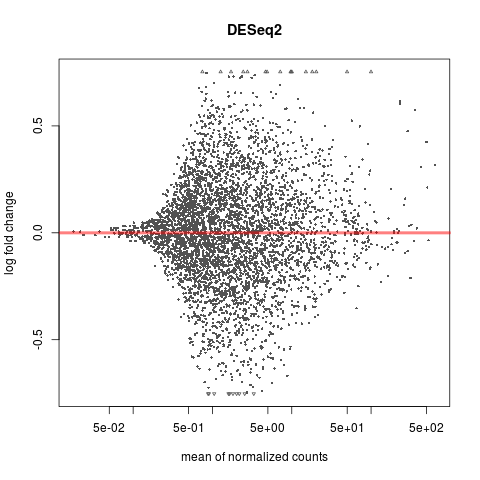

In [37]:
%%R

plotMA(res, main="DESeq2")

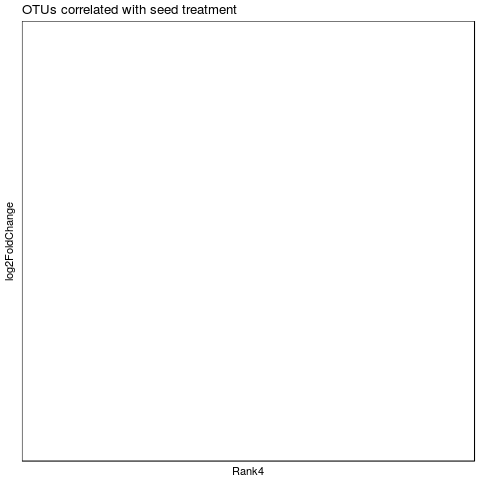

In [38]:
%%R
sigtab = ST %>% filter(padj < 0.1)
x = tapply(sigtab$log2FoldChange, sigtab$Rank4, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank4 = factor(as.character(sigtab$Rank4), levels=names(x))
# x = tapply(sigtab$log2FoldChange, sigtab$Rank3, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Rank3 = factor(as.character(sigtab$Rank3), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank4, y=log2FoldChange, size = baseMean)) + 
    geom_point(aes(color = Rank2))+
  theme_pub() +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("OTUs correlated with seed treatment")  +
   theme(legend.position="right")
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
    p2

## ADONIS at T2

In [114]:
%%R
# subset phyloseq object
physeq.plantT2 = subset_samples(physeq,  Planted == "Rhizosphere" & TimePoint == "T2" & SeedTreatment == "Treated")
physeq.plantT2

# create unifrac distance matrix
registerDoParallel(cores=28)
T2.wunif.dist = distance(physeq.plantT2, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [115]:
%%R
set.seed(101)

df = as(sample_data(physeq.plantT2), "data.frame")
d = T2.wunif.dist
T2adonis = adonis(formula = d ~ Rep + ERA, df, permutations = 999)
T2adonis


Call:
adonis(formula = d ~ Rep + ERA, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)    
Rep        3   0.06037 0.0201233 2.96292 0.16953  0.001 ***
ERA        1   0.00370 0.0036972 0.54438 0.01038  0.869    
Residuals 43   0.29204 0.0067917         0.82009           
Total     47   0.35611                   1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [87]:
%%R
# subset phyloseq object
physeq.plantT2 = subset_samples(physeq,  Planted == "Rhizosphere" & TimePoint == "T2" & SeedTreatment == "Untreated")
physeq.plantT2

# create unifrac distance matrix
registerDoParallel(cores=28)
T2.wunif.dist = distance(physeq.plantT2, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [88]:
%%R
set.seed(101)

df = as(sample_data(physeq.plantT2), "data.frame")
d = T2.wunif.dist
T2adonis = adonis(formula = d ~ Rep + Genotype, df, permutations = 999)
T2adonis


Call:
adonis(formula = d ~ Rep + Genotype, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)
Rep        3  0.025821 0.0086071 1.29121 0.24405  0.199
Genotype   3  0.019987 0.0066624 0.99947 0.18891  0.471
Residuals  9  0.059993 0.0066659         0.56703       
Total     15  0.105802                   1.00000       


# T3

In [79]:
%%R
# subset phyloseq object
physeq.plantT3 = subset_samples(physeq,  Planted == "Rhizosphere" & TimePoint == "T3")
physeq.plantT3

# create unifrac distance matrix
registerDoParallel(cores=28)
T3.wunif.dist = distance(physeq.plantT3, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [81]:
%%R
set.seed(101)

df = as(sample_data(physeq.plantT3), "data.frame")
d = T3.wunif.dist
T3adonis = adonis(formula = d ~ Rep + Genotype*Fert, df, permutations = 999)
T3adonis


Call:
adonis(formula = d ~ Rep + Genotype * Fert, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

              Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Rep            3   0.05344 0.017813  2.8936 0.09583  0.001 ***
Genotype       5   0.04636 0.009272  1.5062 0.08314  0.031 *  
Fert           2   0.08259 0.041293  6.7076 0.14810  0.001 ***
Genotype:Fert 10   0.06128 0.006128  0.9954 0.10989  0.508    
Residuals     51   0.31396 0.006156         0.56303           
Total         71   0.55763                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Ordinate 

In [107]:
%%R
# subset phyloseq object
physeq.plantT2 = subset_samples(physeq,  Planted == "Rhizosphere" & TimePoint == "T2")
physeq.plantT2

# create unifrac distance matrix
registerDoParallel(cores=28)
bray = distance(physeq.plantT2, 
                      method = "bray", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [110]:
%%R -w 800 -h 350

pcoa = ordinate(physeq.plantT2, 
                method = "PCoA", 
                distance = bray)

p = plot_ordination(physeq, pcoa, justDF = TRUE)

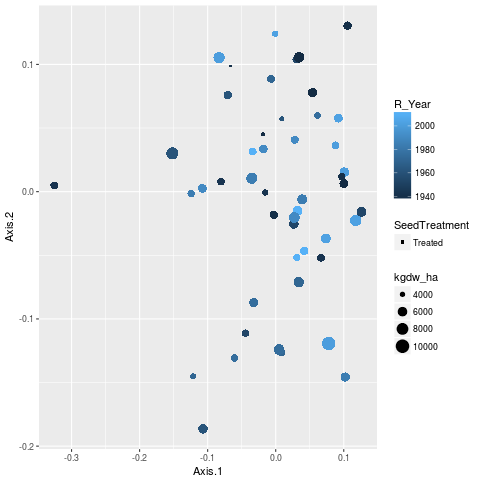

In [117]:
%%R
p1 = ggplot(subset(p, SeedTreatment == "Treated"), aes(x = Axis.1, y = Axis.2)) +
        geom_point(aes(color=R_Year, shape = SeedTreatment, size = kgdw_ha))
        
p1

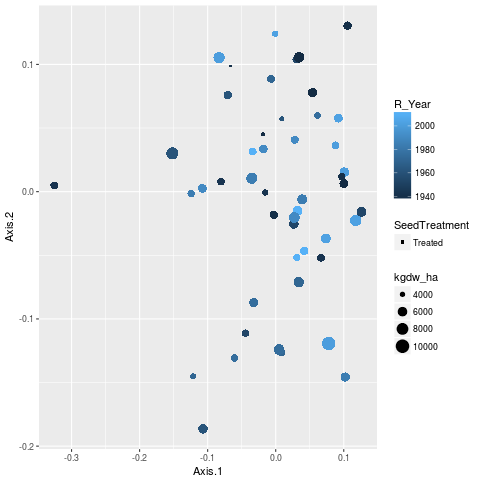

In [117]:
%%R
p1 = ggplot(subset(p, SeedTreatment == "Treated"), aes(x = Axis.1, y = Axis.2)) +
        geom_point(aes(color=R_Year, shape = SeedTreatment, size = kgdw_ha))
        
p1

# T3

In [118]:
%%R
# subset phyloseq object
physeq.plantT3 = subset_samples(physeq,  Planted == "Rhizosphere" & TimePoint == "T3")
physeq.plantT3

# # create unifrac distance matrix
# registerDoParallel(cores=28)
# bray = distance(physeq.plantT3, 
#                       method = "bray", 
#                       weighted = TRUE,
#                       fast = TRUE, 
#                       parallel = TRUE, 
#                       normalized = FALSE)




phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4594 taxa and 72 samples ]
sample_data() Sample Data:       [ 72 samples by 33 sample variables ]
tax_table()   Taxonomy Table:    [ 4594 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4594 tips and 4593 internal nodes ]


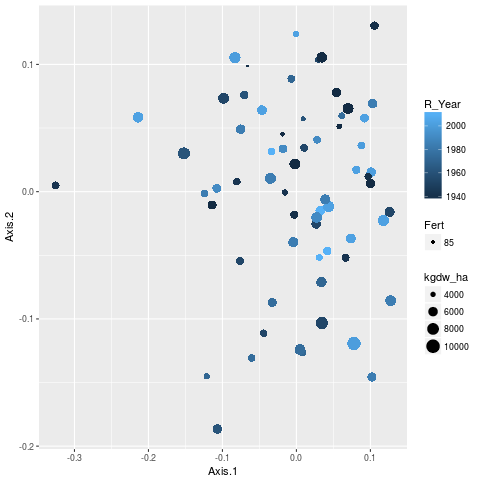

In [120]:
%%R
pcoa = ordinate(physeq.plantT3, 
                method = "PCoA", 
                distance = bray)

p = plot_ordination(physeq, pcoa, justDF = TRUE)

p1 = ggplot(p, aes(x = Axis.1, y = Axis.2)) +
        geom_point(aes(color=R_Year, shape = Fert, size = kgdw_ha))
        
p1


# Mantel tests

## T1

In [121]:
%%R
phy = subset_samples(physeq, Planted == "Rhizosphere" & TimePoint == "T1")
phy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4594 taxa and 72 samples ]
sample_data() Sample Data:       [ 72 samples by 33 sample variables ]
tax_table()   Taxonomy Table:    [ 4594 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4594 tips and 4593 internal nodes ]


* generate distance matrices


In [138]:
%%R

registerDoParallel(cores=28)

Time.wunif.dist = phyloseq::distance(phy, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

Time.bray.dist = phyloseq::distance(phy, 
                      method = "bray", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


Partial Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel.partial(xdis = Time.bray.dist, ydis = Yd, zdis = Rd, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.04811 
      Significance: 0.113 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0506 0.0668 0.0784 0.0940 
Permutation: free
Number of permutations: 999



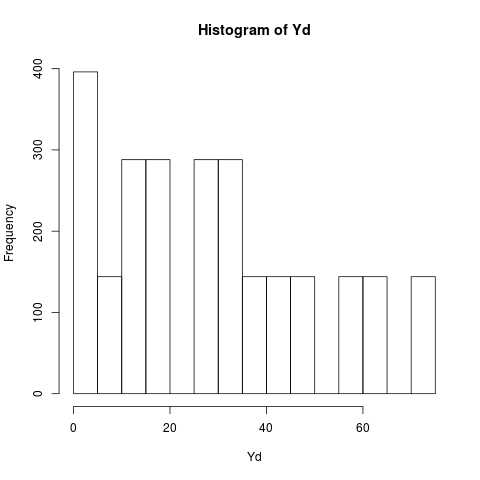

In [137]:
%%R
#Test on soil activity/rhizosphere effect
Sd = sample_data(phy)

# Generate distance matrix of year of release
Yd = dist(Sd[,"R_Year"], method = "euclidian")
hist(Yd)

# generate distance matrix of rep and change all values > 1 to 1
Rd = dist(Sd[,"Rep"])
Rd[Rd > 1] <- 1


M1 = mantel.partial(Time.wunif.dist, Yd, Rd, method="pearson", permutations=999)
M1
#Model is not significant within T1 

## T2

In [139]:
%%R
# subset phyloseq object to just rhizosphere plants, time point 2 and only treated seeds
phy = subset_samples(physeq, Planted == "Rhizosphere" & TimePoint == "T2" & SeedTreatment == "Treated")
phy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4594 taxa and 48 samples ]
sample_data() Sample Data:       [ 48 samples by 33 sample variables ]
tax_table()   Taxonomy Table:    [ 4594 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4594 tips and 4593 internal nodes ]


* generate distance matrices


In [140]:
%%R

registerDoParallel(cores=28)

Time.wunif.dist = phyloseq::distance(phy, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

Time.bray.dist = phyloseq::distance(phy, 
                      method = "bray", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


Partial Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel.partial(xdis = Time.bray.dist, ydis = Yd, zdis = Rd, method = "pearson",      permutations = 999) 

Mantel statistic r: -0.06027 
      Significance: 0.889 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0676 0.0818 0.0972 0.1220 
Permutation: free
Number of permutations: 999



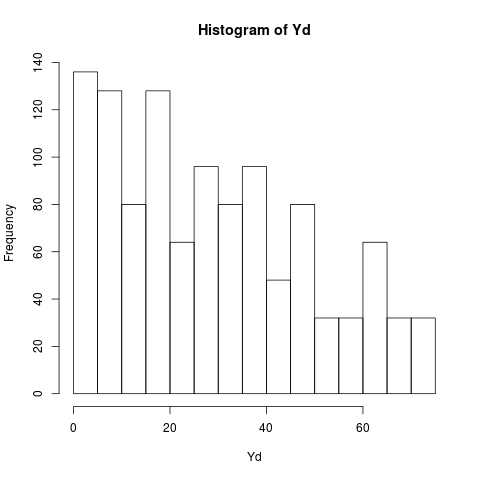

In [144]:
%%R
#Test on soil activity/rhizosphere effect
Sd = sample_data(phy)

# Generate distance matrix of year of release
Yd = dist(Sd[,"R_Year"], method = "euclidian")
hist(Yd)

# generate distance matrix of rep and change all values > 1 to 1
Rd = dist(Sd[,"Rep"])
Rd[Rd > 1] <- 1


M1 = mantel.partial(Time.bray.dist, Yd, Rd, method="pearson", permutations=999)
M1
#Model is not significant within T2

## T3

In [145]:
%%R
# subset phyloseq object to just rhizosphere plants, time point 2 and only treated seeds
phy = subset_samples(physeq, Planted == "Rhizosphere" & TimePoint == "T3")
phy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4594 taxa and 72 samples ]
sample_data() Sample Data:       [ 72 samples by 33 sample variables ]
tax_table()   Taxonomy Table:    [ 4594 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4594 tips and 4593 internal nodes ]


* generate distance matrices


In [146]:
%%R

registerDoParallel(cores=28)

Time.wunif.dist = phyloseq::distance(phy, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

Time.bray.dist = phyloseq::distance(phy, 
                      method = "bray", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


Partial Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel.partial(xdis = Time.bray.dist, ydis = Yd, zdis = Rd, method = "pearson",      permutations = 999) 

Mantel statistic r: -0.0175 
      Significance: 0.67 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0491 0.0686 0.0804 0.0926 
Permutation: free
Number of permutations: 999



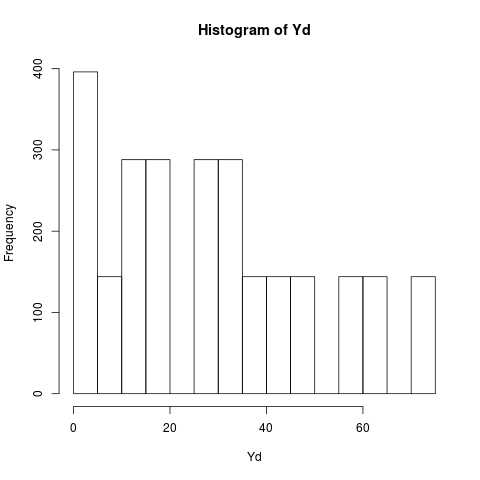

In [147]:
%%R
#Test on soil activity/rhizosphere effect
Sd = sample_data(phy)

# Generate distance matrix of year of release
Yd = dist(Sd[,"R_Year"], method = "euclidian")
hist(Yd)

# generate distance matrix of rep and change all values > 1 to 1
Rd = dist(Sd[,"Rep"])
Rd[Rd > 1] <- 1


M1 = mantel.partial(Time.bray.dist, Yd, Rd, method="pearson", permutations=999)
M1
#Model is not significant within T3

In [ ]:
* Partial mantel test is not significant at any time point

# CAP

In [148]:
%%R
# subset phyloseq object to just rhizosphere plants, time point 2 and only treated seeds
phy = subset_samples(physeq, Planted == "Rhizosphere" & TimePoint == "T2" & SeedTreatment == "Treated")
phy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4594 taxa and 48 samples ]
sample_data() Sample Data:       [ 48 samples by 33 sample variables ]
tax_table()   Taxonomy Table:    [ 4594 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4594 tips and 4593 internal nodes ]


In [149]:
%%R
T2.wunif.dist = phyloseq::distance(phy, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [152]:
%%R
sample_data(phy) %>% colnames

 [1] "X.sampleID"      "TubeID"          "ExtractionPlate" "PooledDNAPlate" 
 [5] "SampleWellID"    "PrimerPlate"     "PrimerNumber"    "PrimerWell"     
 [9] "primerFwdLoc"    "primerRevLoc"    "fwd_barcode"     "rev_barcode"    
[13] "PlotID"          "TimePoint"       "Rep"             "Row"            
[17] "Pos"             "Fert"            "PlotIndex"       "Plant"          
[21] "Genotype"        "SeedTreatment"   "R_Year"          "ERA"            
[25] "kgdw_ha"         "FracN.leco"      "FracC.leco"      "d15N"           
[29] "X15N_AtPercent"  "FracN"           "FracN_fromSoil"  "FracN_fromFert" 
[33] "Planted"        


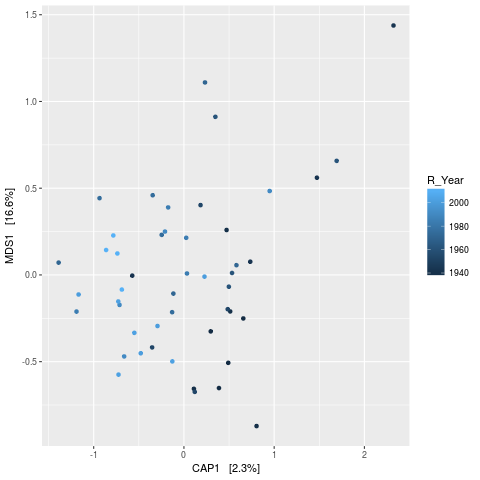

In [171]:
%%R
sample_data(phy)$Rep = as.factor(sample_data(phy)$Rep)
# cap.ord = ordinate(
#     physeq = phy, 
#     method = "CAP",
#     distance = T2.wunif.dist,
#     formula = ~ R_Year + Rep + Condition())

ordcap = ordinate(phy, "CAP", "bray", ~R_Year + Condition(ExtractionPlate))
plot_ordination(phy, ordcap, "samples", color="R_Year")




# # CAP plot
# cap.plot <- plot_ordination(phy, cap.ord, axes = c(1,2)) + 
#     geom_point(aes(fill = Genotype), pch= 21,alpha= 1) 
    #geom_point(colour = "grey90", 
    #    size = 1.5) + 
    
    #scale_color_manual(values = c("#1CE6FF","#B79762", "#004D43", "#8FB0FF", "#997D87", "#5A0007"), name = "Genotype",
 #                      labels = c("B73xB97", "B73xTx303", "ECHES","FAGES","HELAN",     "SORSUD")) 




# Now add the environmental variables as arrows
# arrowmat <- vegan::scores(cap.ord, display = "bp")

# rownames(arrowmat) = c("R_Year", "Rep")
# #rownames(arrowmat) = c("BX", "CB", "LAP", "NAG")

# # Add labels, make a data.frame
# arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

# Define the arrow aesthetic mapping
# arrow_map <- aes(xend = CAP1, 
#     yend = CAP2, 
#     x = 0, 
#     y = 0, 
#     shape = NULL, 
#     color = NULL, 
#     label = labels)

# label_map <- aes(x = 1.3 * CAP1, 
#     y = 1.3 * CAP2, 
#     shape = NULL, 
#     color = NULL, 
#     label = labels)

# arrowhead = arrow(length = unit(0.02, "npc"))

# # Make a new graphic
# p = cap.plot + 
# geom_segment(arrow_map, 
#     size = .5, 
#     data = arrowdf, 
#     color = "gray", 
#     arrow = arrowhead
#     ) + 
# geom_text(label_map,   
#     data = arrowdf, 
#     show_guide = FALSE) 
# p = p + theme_pub() 
# #p = p + theme(panel.border = element_blank(), legend.position = "right", legend.text = element_text(size = 10)) 
# p = p + theme(legend.position = "left", legend.text = element_text()) 

#save legend for independent formatting
# g_legend<-function(a.gplot){
#     tmp <- ggplot_gtable(ggplot_build(a.gplot))
#     leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
#     legend <- tmp$grobs[[leg]]
#     legend
# }
# 

                        
#legend1 <- g_legend(p)

                     
# p =  p + theme(axis.line.x = element_line(color="black", size = 1),
#     axis.line.y = element_line(color="black", size = 1), legend.position = "left")
# p = p + theme(legend.position = "bottom")
# p

In [172]:
%%R
anova(ordcap)

Permutation test for capscale under reduced model
Permutation: free
Number of permutations: 999

Model: capscale(formula = OTU ~ R_Year + Condition(ExtractionPlate), data = data, distance = distance)
         Df SumOfSqs      F Pr(>F)
Model     1  0.04424 1.0031  0.412
Residual 42  1.85254              


## Finally try DESeq2

In [184]:
%%R 
# loading

phy.thresh = readRDS('ERA_thresh.rds')

#Subset to T2
phy.thresh = subset_samples(phy.thresh, TimePoint == "T2" & SeedTreatment == "Treated", TRUE)
phy.thresh

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4594 taxa and 48 samples ]
sample_data() Sample Data:       [ 48 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 4594 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4594 tips and 4593 internal nodes ]


In [51]:
%%R
sample_data(phy.thresh)$Rep = as.factor(sample_data(phy.thresh)$Rep)
sample_data(phy.thresh)$Row = as.factor(sample_data(phy.thresh)$Row)
sample_data(phy.thresh)$Fert = as.factor(sample_data(phy.thresh)$Fert)

In [186]:
%%R
dds = phyloseq_to_deseq2(phy.thresh, ~Rep + R_Year)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(phy)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

DF$Test = "R_Year"
        YR = DF

/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: the design formula contains a numeric variable with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: estimating size factors

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: estimating dispersions

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: gene-wise dispersion estimates: 38 workers

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: mean-dispersion relationship

  warnings.war

[1] "Intercept" "Rep"       "R_Year"   


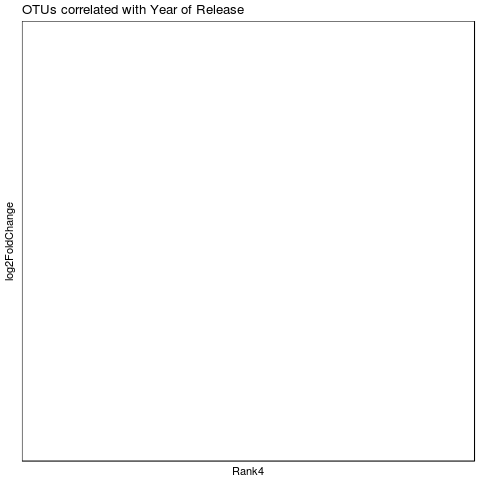

In [189]:
%%R
sigtab = YR %>% filter(padj < 0.1)
x = tapply(sigtab$log2FoldChange, sigtab$Rank4, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank4 = factor(as.character(sigtab$Rank4), levels=names(x))
# x = tapply(sigtab$log2FoldChange, sigtab$Rank3, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Rank3 = factor(as.character(sigtab$Rank3), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank4, y=log2FoldChange, size = baseMean)) + 
    geom_point(aes(color = Rank2))+
  theme_pub() +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("OTUs correlated with Year of Release")  +
   theme(legend.position="right")
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
    p2

# old notebook from Penn below

### T1 with FAGES

In [185]:
%%R
# subset phyloseq object
physeq.core = subset_samples(physeq.snorm, Genotype %in% c("FAGES", "ECHES", "SORSUD", "HELAN", 
                                                           "B73xB97", "B73xTx303") & TimePoint == "T1"
                            & Ntreat == "Nneg")

# create unifrac distance matrix
registerDoParallel(cores=28)
wunif.dist = distance(physeq.core, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [186]:
%%R
set.seed(101)

df = as(sample_data(physeq.core), "data.frame")
d = wunif.dist
Coreadonis = adonis(formula = d ~  Rep + Genotype, df, permutations = 999)
Coreadonis


Call:
adonis(formula = d ~ Rep + Genotype, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)  
Rep        3   0.07287 0.024290  1.9437 0.19680  0.041 *
Genotype   5   0.10995 0.021991  1.7597 0.29695  0.034 *
Residuals 15   0.18745 0.012497         0.50625         
Total     23   0.37027                  1.00000         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
### Just FAGES to evaluate N treatment

In [214]:
%%R

# subset phyloseq object
physeq.core = subset_samples(physeq.snorm, Genotype %in% c("FAGES") & TimePoint == "T1")

# create unifrac distance matrix
registerDoParallel(cores=28)
wunif.dist = distance(physeq.core, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [216]:
%%R
set.seed(101)

df = as(sample_data(physeq.core), "data.frame")
d = wunif.dist
Coreadonis = adonis(formula = d ~  Rep + Ntreat, df, permutations = 999)
Coreadonis


Call:
adonis(formula = d ~ Rep + Ntreat, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)  
Rep        3  0.052604 0.0175346  4.6218 0.75785  0.011 *
Ntreat     1  0.005427 0.0054267  1.4304 0.07818  0.344  
Residuals  3  0.011382 0.0037939         0.16397         
Total      7  0.069412                   1.00000         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### T1 ADONIS with species effect

In [146]:
%%R
# subset phyloseq object
physeq.core = subset_samples(physeq.snorm, Genotype %in% c("FAGES", "ECHES", "SORSUD", "HELAN", 
                                                           "B73xB97", "B73xTx303") & TimePoint == "T1"
                            & Ntreat == "Nneg")

# create unifrac distance matrix
registerDoParallel(cores=28)
wunif.dist = distance(physeq.core, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [147]:
%%R
set.seed(101)

df = as(sample_data(physeq.core), "data.frame")
d = wunif.dist
Coreadonis = adonis(formula = d ~  Rep + Species, df, permutations = 999)
Coreadonis


Call:
adonis(formula = d ~ Rep + Species, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)  
Rep        3  0.061788 0.020596  1.5573 0.20928  0.091 .
Species    3  0.061532 0.020511  1.5509 0.20841  0.128  
Residuals 13  0.171925 0.013225         0.58231         
Total     19  0.295245                  1.00000         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


* At T1 there is a species effect largely driven by buckwheat contrasting with sorghum, but very different developmental stages
* Analysis does not change if done by species instead of genotype

### NMDS of T1

Run 0 stress 0.09667845 
Run 1 stress 0.09634453 
... New best solution
... Procrustes: rmse 0.0552801  max resid 0.2326979 
Run 2 stress 0.1300506 
Run 3 stress 0.1351778 
Run 4 stress 0.09435499 
... New best solution
... Procrustes: rmse 0.02576955  max resid 0.07659165 
Run 5 stress 0.09667822 
Run 6 stress 0.09667372 
Run 7 stress 0.0943568 
... Procrustes: rmse 0.001143634  max resid 0.004066788 
... Similar to previous best
Run 8 stress 0.1300296 
Run 9 stress 0.135878 
Run 10 stress 0.1357515 
Run 11 stress 0.1405649 
Run 12 stress 0.1388104 
Run 13 stress 0.09667621 
Run 14 stress 0.09435525 
... Procrustes: rmse 0.0006116764  max resid 0.002260726 
... Similar to previous best
Run 15 stress 0.09634685 
Run 16 stress 0.3834313 
Run 17 stress 0.09667413 
Run 18 stress 0.09642056 
Run 19 stress 0.09667573 
Run 20 stress 0.09435516 
... Procrustes: rmse 0.0005707016  max resid 0.002057922 
... Similar to previous best
*** Solution reached


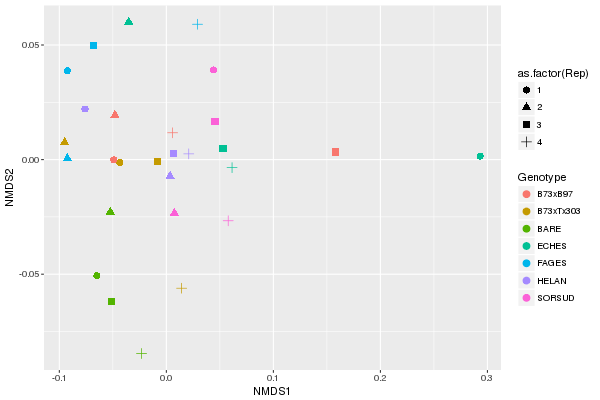

In [117]:
%%R -w 600 -h 400
# subset phyloseq object, include FAGES and bare soil
physeq.core = subset_samples(physeq.snorm, Genotype %in% c("BARE", "FAGES", "ECHES", "SORSUD", "HELAN", 
                                                           "B73xB97", "B73xTx303") & TimePoint == "T1"
                            & Ntreat == "Nneg")

# create unifrac distance matrix
registerDoParallel(cores=28)
wunif.dist = distance(physeq.core, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

nmds = ordinate(physeq.core, 
                method = "NMDS", 
                distance = wunif.dist)

p = plot_ordination(physeq.core, nmds, justDF = TRUE)

p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(color= Genotype, shape = as.factor(Rep)), size = 3)
        #scale_size(range=c(2,8))
p1

## ADONIS of T3

In [259]:
%%R
# subset phyloseq object
physeq.core = subset_samples(physeq.snorm, Genotype %in% c("FAGES", "ECHES", "SORSUD", "HELAN",
                                                           "B73xB97", "B73xTx303") & TimePoint == "T3")

# create unifrac distance matrix
registerDoParallel(cores=28)
wunif.dist = distance(physeq.core, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [260]:
%%R
set.seed(101)

df = as(sample_data(physeq.core), "data.frame")
d = wunif.dist
Coreadonis = adonis(formula = d ~  Rep +  Rep:Genotype + Genotype*Ntreat, df, permutations = 999)
Coreadonis


Call:
adonis(formula = d ~ Rep + Rep:Genotype + Genotype * Ntreat,      data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Rep              3   0.12273 0.040910  6.0051 0.21168  0.001 ***
Genotype         5   0.14264 0.028529  4.1876 0.24602  0.001 ***
Ntreat           1   0.01229 0.012287  1.8036 0.02119  0.071 .  
Rep:Genotype    15   0.14873 0.009915  1.4554 0.25652  0.012 *  
Genotype:Ntreat  5   0.03079 0.006157  0.9038 0.05310  0.631    
Residuals       18   0.12263 0.006813         0.21150           
Total           47   0.57980                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### NMDS of T3

In [261]:
%%R
nmds = ordinate(physeq.core, 
                method = "NMDS", 
                distance = wunif.dist)

p = plot_ordination(physeq.core, nmds, justDF = TRUE)

Run 0 stress 0.1471425 
Run 1 stress 0.2037228 
Run 2 stress 0.180154 
Run 3 stress 0.2010578 
Run 4 stress 0.179921 
Run 5 stress 0.1471414 
... New best solution
... Procrustes: rmse 0.0004492155  max resid 0.002238368 
... Similar to previous best
Run 6 stress 0.2102671 
Run 7 stress 0.2117794 
Run 8 stress 0.1472299 
... Procrustes: rmse 0.004061768  max resid 0.02366752 
Run 9 stress 0.1472298 
... Procrustes: rmse 0.004045805  max resid 0.02358663 
Run 10 stress 0.2130612 
Run 11 stress 0.1485645 
Run 12 stress 0.1518948 
Run 13 stress 0.1485646 
Run 14 stress 0.2107415 
Run 15 stress 0.171597 
Run 16 stress 0.1957077 
Run 17 stress 0.1800069 
Run 18 stress 0.1471417 
... Procrustes: rmse 0.0003351704  max resid 0.001655147 
... Similar to previous best
Run 19 stress 0.1518934 
Run 20 stress 0.4012686 
*** Solution reached


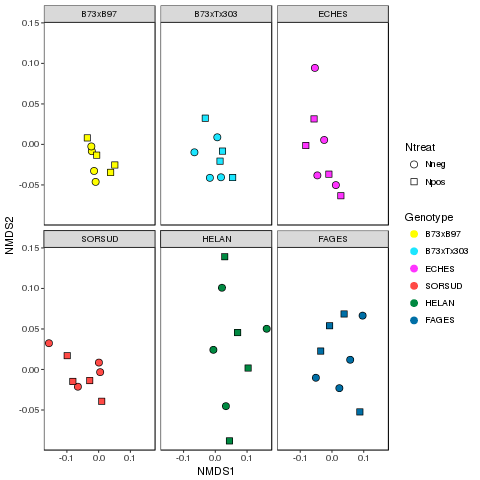

In [263]:
%%R
p$Genotype = factor(p$Genotype, levels = c("B73xB97", "B73xTx303",  "ECHES", 
                                                       "SORSUD", "HELAN", "FAGES"))
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill = Genotype, shape = Ntreat), size = 3) + 
           scale_shape_manual(values=c(21, 22)) +
        scale_fill_manual(values = c("#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46",
                                        "#008941", "#006FA6")) +
        theme_pub()+
        guides(fill=guide_legend(override.aes=list(colour= c("#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46",
                                      "#008941", "#006FA6")))) +
        facet_wrap(~Genotype)
      
p1


## ADONIS of T4

In [210]:
%%R
# subset phyloseq object
physeq.core = subset_samples(physeq.snorm, Genotype %in% c("ECHES", "SORSUD", "HELAN", 
                                                           "B73xB97", "B73xTx303") & TimePoint == "T4")

# create unifrac distance matrix
registerDoParallel(cores=28)
wunif.dist = distance(physeq.core, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [211]:
%%R
set.seed(101)

df = as(sample_data(physeq.core), "data.frame")
d = wunif.dist
Coreadonis = adonis(formula = d ~ Rep +  Rep:Genotype + Genotype*Ntreat, df, permutations = 999)
Coreadonis


Call:
adonis(formula = d ~ Rep + Rep:Genotype + Genotype * Ntreat,      data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Rep              3   0.07774 0.025912  2.9093 0.11643  0.002 ** 
Genotype         4   0.26318 0.065796  7.3871 0.39419  0.001 ***
Ntreat           1   0.01302 0.013025  1.4623 0.01951  0.169    
Rep:Genotype    12   0.13270 0.011058  1.2416 0.19876  0.161    
Genotype:Ntreat  4   0.04740 0.011851  1.3305 0.07100  0.137    
Residuals       15   0.13360 0.008907         0.20011           
Total           39   0.66765                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## nmds of core plants

In [196]:
%%R -w 800 -h 350
# subset phyloseq object, include FAGES and bare soil
physeq.core = subset_samples(physeq.snorm, Genotype %in% c("BARE", "FAGES", "ECHES", "SORSUD", "HELAN", 
                                                           "B73xB97", "B73xTx303")  &
                                                     TimePoint %in% c("T1", "T3", "T4"))

sample_data(physeq.core)$Genotype = factor(sample_data(physeq.core)$Genotype, 
                                            levels = c("BARE", "B73xB97", "B73xTx303",  "ECHES", 
                                                       "SORSUD", "HELAN", "FAGES"))

# create unifrac distance matrix
registerDoParallel(cores=28)
wunif.dist = distance(physeq.core, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

nmds = ordinate(physeq.core, 
                method = "NMDS", 
                distance = wunif.dist)

p = plot_ordination(physeq.core, nmds, justDF = TRUE)



Run 0 stress 0.1277908 
Run 1 stress 0.1354406 
Run 2 stress 0.1354415 
Run 3 stress 0.12779 
... New best solution
... Procrustes: rmse 0.0003338269  max resid 0.002567065 
... Similar to previous best
Run 4 stress 0.1277894 
... New best solution
... Procrustes: rmse 0.0002413285  max resid 0.002114727 
... Similar to previous best
Run 5 stress 0.1277964 
... Procrustes: rmse 0.0008001607  max resid 0.007888117 
... Similar to previous best
Run 6 stress 0.1354389 
Run 7 stress 0.127798 
... Procrustes: rmse 0.0008260246  max resid 0.007942033 
... Similar to previous best
Run 8 stress 0.1277899 
... Procrustes: rmse 0.0002621751  max resid 0.002134339 
... Similar to previous best
Run 9 stress 0.1277904 
... Procrustes: rmse 0.000243861  max resid 0.002085954 
... Similar to previous best
Run 10 stress 0.1277911 
... Procrustes: rmse 0.0004501946  max resid 0.004835938 
... Similar to previous best
Run 11 stress 0.1354411 
Run 12 stress 0.1277895 
... Procrustes: rmse 2.186979e-05  m

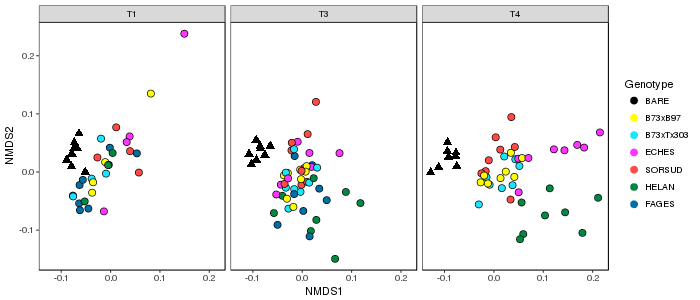

In [200]:
%%R -w 700 -h 300
## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(shape = Planted, fill = Genotype), size = 3) + 
        scale_shape_manual(values=c(17, 21), guide = FALSE) +
        scale_fill_manual(values = c("#000000", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46",
                                        "#008941", "#006FA6")) +
        theme_pub()+
        guides(fill=guide_legend(override.aes=list(colour= c("#000000", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46",
                                      "#008941", "#006FA6")))) +
        facet_wrap(~TimePoint)
      
p1



# Intraspecific variation

In [25]:
%%R
physeq.snorm %>% 
    sample_data() %>% 
    select(Genotype) %>%
    unique

Sample Data:        [14 samples by 1 sample variables]:
                   Genotype
Penn-T2_2-4b_Nneg       354
Penn-T3_1-4a_Nneg   B73xB97
Penn-T3_1-4c_Nneg     ECHES
Penn-T3_1-3a_Npos     FAGES
Penn-T0_4-2b_Nneg      BARE
Penn-T2_4-3c_Nneg B73xIl14H
Penn-T3_1-3c_Nneg    SORSUD
Penn-T4_1-1b_Nneg B73xTx303
Penn-T3_3-1b_Nneg     HELAN
Penn-T2_2-3a_Nneg    EX3101
Penn-T2_4-1a_Nneg      3475
Penn-T3_1-4b_Nneg   M71xB73
Penn-T2_4-5a_Nneg       322
Penn-T3_1-1c_Nneg  B73xOh7B


In [26]:
%%R
physeq.maize = subset_samples(physeq.snorm, Genotype %in% c("322", "354", "3475") & TimePoint %in% c("T2", 
                                                                                                                "T3"))

In [27]:
%%R

# create unifrac distance matrix
registerDoParallel(cores=28)
wunif.dist = distance(physeq.maize, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [28]:
%%R
set.seed(101)

df = as(sample_data(physeq.maize), "data.frame")
d = wunif.dist
Maizeadonis = adonis(formula = d ~ as.factor(Rep) + Genotype, df, permutations = 999)
Maizeadonis


Call:
adonis(formula = d ~ as.factor(Rep) + Genotype, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

               Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)   
as.factor(Rep)  3  0.061724 0.0205748  3.5658 0.57662  0.002 **
Genotype        2  0.010700 0.0053499  0.9272 0.09996  0.483   
Residuals       6  0.034620 0.0057700         0.32342          
Total          11  0.107044                   1.00000          
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Ordinate Maize

In [228]:
%%R
physeq.maize = subset_samples(physeq.snorm, Genotype %in% c("354", "322", "3475", "M71xB73", "B73xIl14H", "B73xOh7B", 
                                                           "EX3101", "B73xB97", "B73xTx303") & 
                                                          TimePoint %in% c("T2", "T3"))

# create unifrac distance matrix
registerDoParallel(cores=28)
wunif.dist = distance(physeq.maize, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


nmds = ordinate(physeq.maize, 
                method = "NMDS", 
                distance = wunif.dist)

p = plot_ordination(physeq.maize, nmds, justDF = TRUE)



Run 0 stress 0.1424988 
Run 1 stress 0.1424988 
... Procrustes: rmse 6.456495e-06  max resid 2.605529e-05 
... Similar to previous best
Run 2 stress 0.1624679 
Run 3 stress 0.1425113 
... Procrustes: rmse 0.00311896  max resid 0.01637097 
Run 4 stress 0.1425113 
... Procrustes: rmse 0.003116571  max resid 0.01636921 
Run 5 stress 0.1425113 
... Procrustes: rmse 0.003118038  max resid 0.01637107 
Run 6 stress 0.1425113 
... Procrustes: rmse 0.003116711  max resid 0.0163735 
Run 7 stress 0.1424988 
... New best solution
... Procrustes: rmse 5.426444e-06  max resid 2.37253e-05 
... Similar to previous best
Run 8 stress 0.1425113 
... Procrustes: rmse 0.003116718  max resid 0.01637802 
Run 9 stress 0.1425113 
... Procrustes: rmse 0.003117222  max resid 0.01637588 
Run 10 stress 0.1425115 
... Procrustes: rmse 0.003117421  max resid 0.01637346 
Run 11 stress 0.1425113 
... Procrustes: rmse 0.003116945  max resid 0.01637429 
Run 12 stress 0.1624679 
Run 13 stress 0.1425113 
... Procrustes: r

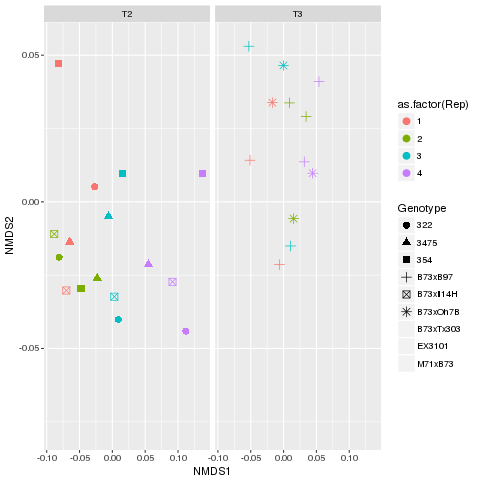

In [229]:
%%R
## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(color=as.factor(Rep), shape = Genotype), size = 3) + 
        facet_wrap(~TimePoint)
        #scale_size(range=c(2,8))
p1

In [233]:
%%R
physeq.maize %>% 
    sample_data() %>%
    filter(TimePoint %in% c("T2","T3")) %>%
    select(Genotype, Ntreat) %>% 
    unique

    Genotype Ntreat
1        354   Nneg
2    B73xB97   Nneg
3  B73xIl14H   Nneg
5  B73xTx303   Npos
6     EX3101   Nneg
7       3475   Nneg
10   M71xB73   Nneg
12       322   Nneg
16 B73xTx303   Nneg
18  B73xOh7B   Nneg
22   B73xB97   Npos


In [235]:
%%R
physeq.maize = subset_samples(physeq.snorm, Genotype %in% c("354", "322", "3475", "M71xB73", "B73xIl14H", "B73xOh7B", 
                                                           "EX3101", "B73xB97", "B73xTx303") & 
                                                          TimePoint %in% c("T2", "T3") & Ntreat == "Nneg")

# create unifrac distance matrix
registerDoParallel(cores=28)
wunif.dist = distance(physeq.maize, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


df = as(sample_data(physeq.maize), "data.frame")
d = wunif.dist
Maizeadonis = adonis(formula = d ~ Rep + Genotype, df, permutations = 999)
Maizeadonis


Call:
adonis(formula = d ~ Rep + Genotype, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)    
Rep        3  0.092834 0.0309446  4.9812 0.31179  0.001 ***
Genotype   8  0.055815 0.0069768  1.1231 0.18746  0.284    
Residuals 24  0.149094 0.0062122         0.50075           
Total     35  0.297743                   1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [236]:
%%R
## Ntreat at R1 for maize  

physeq.maize = subset_samples(physeq.snorm, Genotype %in% c("B73xB97", "B73xTx303") & 
                                                          TimePoint %in% c("T2", "T3"))

# create unifrac distance matrix
registerDoParallel(cores=28)
wunif.dist = distance(physeq.maize, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


df = as(sample_data(physeq.maize), "data.frame")
d = wunif.dist
Maizeadonis = adonis(formula = d ~ Rep + Genotype*Ntreat, df, permutations = 999)
Maizeadonis


Call:
adonis(formula = d ~ Rep + Genotype * Ntreat, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)    
Rep              3  0.039676 0.0132252 2.74535 0.37819  0.001 ***
Genotype         1  0.004653 0.0046531 0.96590 0.04435  0.435    
Ntreat           1  0.013518 0.0135176 2.80605 0.12885  0.018 *  
Genotype:Ntreat  1  0.003707 0.0037066 0.76944 0.03533  0.620    
Residuals        9  0.043356 0.0048173         0.41327           
Total           15  0.104909                   1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### ordinate just core maize on R1

In [237]:
%%R
nmds = ordinate(physeq.maize, 
                method = "NMDS", 
                distance = wunif.dist)

p = plot_ordination(physeq.maize, nmds, justDF = TRUE)

Run 0 stress 0.09043987 
Run 1 stress 0.09043987 
... New best solution
... Procrustes: rmse 1.125118e-05  max resid 2.893226e-05 
... Similar to previous best
Run 2 stress 0.09043989 
... Procrustes: rmse 5.761777e-05  max resid 0.0001138624 
... Similar to previous best
Run 3 stress 0.09043987 
... New best solution
... Procrustes: rmse 1.231637e-05  max resid 2.728053e-05 
... Similar to previous best
Run 4 stress 0.09043987 
... New best solution
... Procrustes: rmse 2.870841e-06  max resid 6.5351e-06 
... Similar to previous best
Run 5 stress 0.09043987 
... Procrustes: rmse 7.93517e-06  max resid 1.359864e-05 
... Similar to previous best
Run 6 stress 0.09043987 
... Procrustes: rmse 1.10666e-05  max resid 2.546917e-05 
... Similar to previous best
Run 7 stress 0.09043987 
... Procrustes: rmse 2.168535e-05  max resid 4.350097e-05 
... Similar to previous best
Run 8 stress 0.09599275 
Run 9 stress 0.09043987 
... Procrustes: rmse 3.120931e-06  max resid 8.307796e-06 
... Similar t

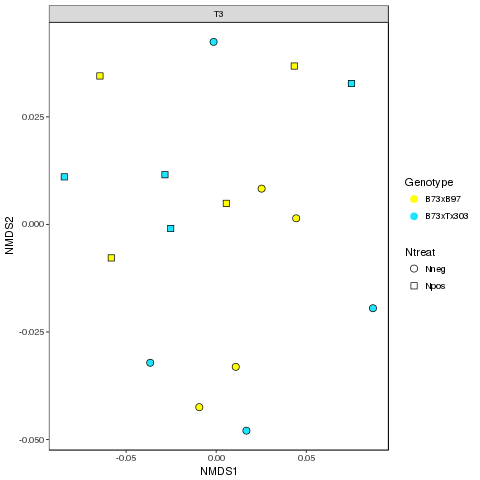

In [244]:
%%R
p$Genotype = factor(p$Genotype, levels = c("B73xB97", "B73xTx303"))
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill = Genotype, shape = Ntreat), size = 3) + 
           scale_shape_manual(values=c(21, 22)) +
        scale_fill_manual(values = c("#FFFF00", "#1CE6FF")) +
        theme_pub()+
        guides(fill=guide_legend(override.aes=list(colour= c("#FFFF00", "#1CE6FF")))) +
        facet_wrap(~TimePoint)
      
p1

# Just maize lines harvested on main date

In [69]:
%%R
physeq.snorm %>% 
    sample_data() %>%
    .$Genotype %>%
    levels

 [1] "322"       "3475"      "354"       "B73xB97"   "B73xIl14H" "B73xOh7B" 
 [7] "B73xTx303" "BARE"      "ECHES"     "EX3101"    "FAGES"     "HELAN"    
[13] "M71xB73"   "SORSUD"   


In [68]:
%%R
physeq.snorm %>% 
    sample_data() %>%
    filter(TimePoint %in% c("T2","T3")) %>%
    select(Genotype) %>% 
    unique

    Genotype
1        354
2    B73xB97
3      ECHES
4      FAGES
5  B73xIl14H
6     SORSUD
8       BARE
11     HELAN
13 B73xTx303
16    EX3101
19      3475
25   M71xB73
27       322
38  B73xOh7B


In [264]:
%%R
physeq.maize = subset_samples(physeq.snorm, Genotype %in% c("322","3475","354","B73xB97","B73xIl14H","B73xOh7B", 
 "B73xTx303", "EX3101","M71xB73") & TimePoint == "T3")

physeq.maize %>%
    sample_data() %>%
    .$Genotype %>%
    unique %>%
    print
# B73xIl14H harvested on T2, so will be removed by filter

[1] B73xB97   B73xTx303 M71xB73   B73xOh7B 
Levels: B73xB97 B73xOh7B B73xTx303 M71xB73


In [265]:
%%R

# create unifrac distance matrix
registerDoParallel(cores=28)
wunif.dist = distance(physeq.maize, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [270]:
%%R
set.seed(101)

df = as(sample_data(physeq.maize), "data.frame")
d = wunif.dist
Maizeadonis = adonis(formula = d ~ Rep + Ntreat*Genotype, df, permutations = 999)
Maizeadonis


Call:
adonis(formula = d ~ Rep + Ntreat * Genotype, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)    
Rep              3  0.048397 0.0161323 3.10838 0.30093  0.001 ***
Ntreat           1  0.014028 0.0140283 2.70297 0.08723  0.010 ** 
Genotype         3  0.016845 0.0056152 1.08193 0.10474  0.329    
Ntreat:Genotype  1  0.003707 0.0037066 0.71419 0.02305  0.707    
Residuals       15  0.077849 0.0051900         0.48406           
Total           23  0.160827                   1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# Maize on T1

In [227]:
%%R
# subset samples and print genotypes included
physeq.maize = subset_samples(physeq.snorm, Genotype %in% c("322","3475","354","B73xB97","B73xIl14H","B73xOh7B", 
 "B73xTx303", "EX3101","M71xB73") & TimePoint == "T1")
physeq.maize %>%
    sample_data() %>%
    .$Genotype %>%
    unique %>%
    print

# calculate weighted UniFrac distances
wunif.dist = distance(physeq.maize, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

# perform permanova
set.seed(101)

df = as(sample_data(physeq.maize), "data.frame")
d = wunif.dist
Maizeadonis = adonis(formula = d ~ Rep + Genotype, df, permutations = 999)
Maizeadonis

[1] B73xTx303 B73xB97   M71xB73  
Levels: B73xB97 B73xTx303 M71xB73

Call:
adonis(formula = d ~ Rep + Genotype, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)  
Rep        3  0.078576 0.026192  2.2879 0.45014  0.052 .
Genotype   2  0.027293 0.013647  1.1920 0.15635  0.340  
Residuals  6  0.068690 0.011448         0.39350         
Total     11  0.174560                  1.00000         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [225]:
%%R
sample_data(physeq.maize) %>%
    filter(Genotype == "M71xB73")

         X.sampleID SampleNumericID Plate primerFR_ID_byPlate primerFR_ID_total
1 Penn-T1_2-2c_Nneg            D-99     1                  75                75
2 Penn-T1_3-1c_Nneg           D-101     2                   7               103
3 Penn-T1_1-4b_Nneg            D-97     1                  12                12
4 Penn-T1_4-5b_Nneg           D-103     2                  34               130
  PrimerWell FwdPrimerID RevPrimerID barcode_ID fwd_barcode rev_barcode
1        C10           3          10         75    TAGCGAGT    TAGCAGAC
2         G1           7           1        103    GATCGTGT    AACTCTCG
3         D2           4           2         12    CTGCGTGT    ACTATGTC
4         B5           2           5        130    CGTTACTA    CGTACTCA
  Experiment TimePoint    PlotID Plot_loc Ntreat Genotype Rep FertStrip Row
1       Penn        T1 2-2c_Nneg     2-2c   Nneg  M71xB73   2         2   c
2       Penn        T1 3-1c_Nneg     3-1c   Nneg  M71xB73   3         1   c
3       Penn

# Maize on T4

In [217]:
%%R
physeq.maize = subset_samples(physeq.snorm, Genotype %in% c("B73xB97","B73xTx303") & TimePoint == "T4")




In [218]:
%%R

# create unifrac distance matrix
registerDoParallel(cores=28)
wunif.dist = distance(physeq.maize, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [219]:
%%R
set.seed(101)

df = as(sample_data(physeq.maize), "data.frame")
d = wunif.dist
Maizeadonis = adonis(formula = d ~ Rep:Genotype + Genotype*Ntreat, df, permutations = 999)
Maizeadonis


Call:
adonis(formula = d ~ Rep:Genotype + Genotype * Ntreat, data = df,      permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)   
Genotype         1  0.005147 0.0051467 0.88221 0.04215  0.534   
Ntreat           1  0.009401 0.0094010 1.61143 0.07699  0.126   
Rep:Genotype     6  0.063434 0.0105723 1.81220 0.51951  0.010 **
Genotype:Ntreat  1  0.009117 0.0091173 1.56281 0.07467  0.131   
Residuals        6  0.035004 0.0058339         0.28667          
Total           15  0.122102                   1.00000          
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [34]:
%%R
cnts = sample_sums(physeq) %>% 
    as.data.frame 
cnts$sample = rownames(cnts)
colnames(cnts)[1] = "reads"
cnts = arrange(cnts, desc(reads))
# ggplot() +
    #    geom_bar(stat = "identity")

In [35]:
%%R
head(cnts)

  reads            sample
1 38331 Penn-T4_1-2b_Npos
2 36144 Penn-T1_1-4c_Nneg
3 35553 Penn-T2_4-3c_Nneg
4 33569 Penn-T4_3-4a_Npos
5 33388 Penn-T4_1-4a_Npos
6 30679 Penn-T4_1-1b_Npos


In [41]:
%%R
cnts$sample = factor(cnts$sample, levels = cnts$sample)
str(cnts)

'data.frame':	188 obs. of  2 variables:
 $ reads : num  38331 36144 35553 33569 33388 ...
 $ sample: Factor w/ 188 levels "Penn-T4_1-2b_Npos",..: 1 2 3 4 5 6 7 8 9 10 ...


In [43]:
%%R
tail(cnts)

    reads            sample
183  4841 Penn-T1_4-5b_Nneg
184  4744 Penn-T2_2-1b_Nneg
185  4241 Penn-T3_4-5b_Nneg
186  4134 Penn-T3_2-4c_Nneg
187  3775 Penn-T4_2-3c_Nneg
188  3133 Penn-T1_2-5c_Nneg


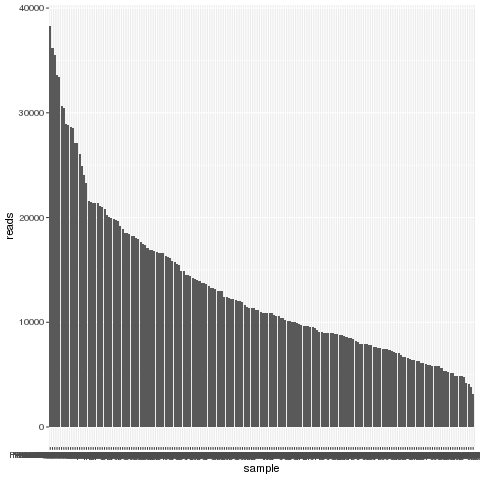

In [42]:
%%R
ggplot(cnts, aes(x = sample, y = reads)) +
      geom_bar(stat = "identity")

# Pseudomonas

In [84]:
%%R
physeq.core %>% 
    tax_table() %>% 
    head()

Taxonomy Table:     [6 taxa by 8 taxonomic ranks]:
         Rank1      Rank2             Rank3               
OTU.1530 "Bacteria" "__Acidobacteria" "__32-21"           
OTU.589  "Bacteria" "__Acidobacteria" "__32-21"           
OTU.1589 "Bacteria" "__Acidobacteria" "__JG37-AG-116"     
OTU.5273 "Bacteria" "__Acidobacteria" "__Acidobacteriales"
OTU.5981 "Bacteria" "__Acidobacteria" "__Acidobacteriales"
OTU.6610 "Bacteria" "__Acidobacteria" "__Acidobacteriales"
         Rank4                    Rank5          Rank6                    Rank7
OTU.1530 "__uncultured_bacterium" NA             NA                       NA   
OTU.589  "__uncultured_bacterium" NA             NA                       NA   
OTU.1589 NA                       NA             NA                       NA   
OTU.5273 "__Acidobacteriaceae"    "__uncultured" "__uncultured_bacterium" NA   
OTU.5981 "__Acidobacteriaceae"    "__uncultured" NA                       NA   
OTU.6610 "__Acidobacteriaceae"    "__uncultured" "__uncu

In [97]:
%%R
pdms = subset_taxa(physeq.snorm, Rank6=="__Pseudomonas") %>%
    subset_samples(Ntreat == "Nneg")
pdms

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 5 taxa and 124 samples ]
sample_data() Sample Data:       [ 124 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 5 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 5 tips and 4 internal nodes ]


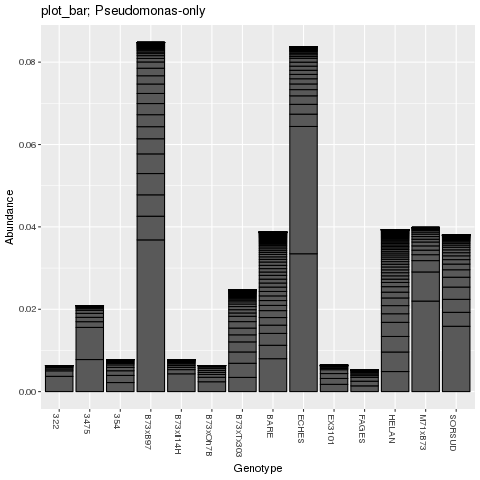

In [98]:
%%R
title = "plot_bar; Pseudomonas-only"
plot_bar(pdms, "Genotype", "Abundance", title=title)

In [99]:
%%R
pdms.mean = psmelt(pdms) %>%
        group_by(OTU,TimePoint, Genotype) %>%
         summarize(relAbundance = mean(Abundance))

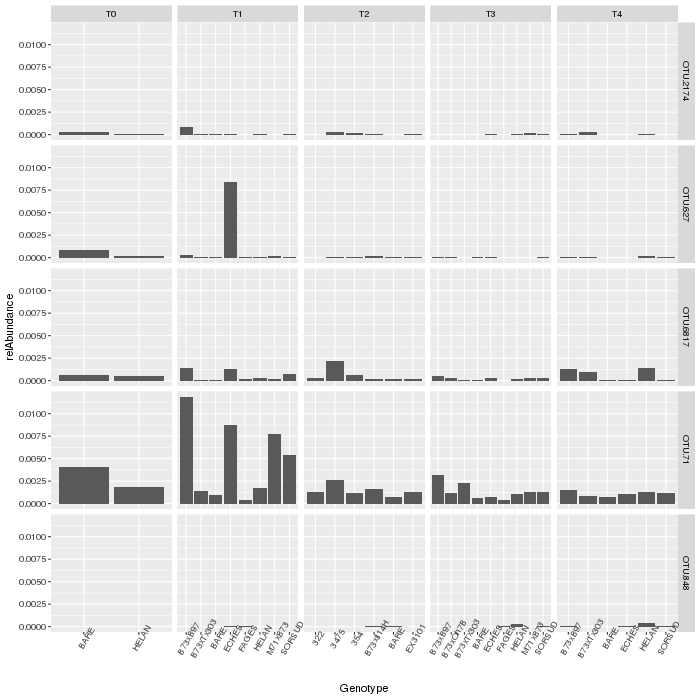

In [100]:
%%R -w 700 -h 700
ggplot(pdms.mean, aes(x = Genotype, y = relAbundance)) +
    geom_bar(stat = "identity") + 
    facet_grid(OTU~TimePoint, scales = "free_x")+
    theme(axis.text.x = element_text(angle = 60))
   # geom_text(aes(y = relAbundance + .001, label=sig))

In [94]:
%%R
tax_table(pdms)

Taxonomy Table:     [5 taxa by 8 taxonomic ranks]:
         Rank1      Rank2              Rank3                  
OTU.627  "Bacteria" "__Proteobacteria" "__Gammaproteobacteria"
OTU.71   "Bacteria" "__Proteobacteria" "__Gammaproteobacteria"
OTU.2174 "Bacteria" "__Proteobacteria" "__Gammaproteobacteria"
OTU.6817 "Bacteria" "__Proteobacteria" "__Gammaproteobacteria"
OTU.848  "Bacteria" "__Proteobacteria" "__Gammaproteobacteria"
         Rank4               Rank5                Rank6          
OTU.627  "__Pseudomonadales" "__Pseudomonadaceae" "__Pseudomonas"
OTU.71   "__Pseudomonadales" "__Pseudomonadaceae" "__Pseudomonas"
OTU.2174 "__Pseudomonadales" "__Pseudomonadaceae" "__Pseudomonas"
OTU.6817 "__Pseudomonadales" "__Pseudomonadaceae" "__Pseudomonas"
OTU.848  "__Pseudomonadales" "__Pseudomonadaceae" "__Pseudomonas"
         Rank7                    Rank8
OTU.627  NA                       NA   
OTU.71   "__uncultured_bacterium" NA   
OTU.2174 NA                       NA   
OTU.6817 NA    